In [1]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import KFold,train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import pandas as pd 
import numpy as np
from math import pi
from featexp import *
import gc
import os
path_train='D:/data_mywork/math_modeling/train_set/'
path_test='D:/data_mywork/math_modeling/test_set/'
path_dir=os.listdir(path_train)
path_dir1=os.listdir(path_test)

In [2]:
def feat(data):
    feat=['Frequency Band','RS Power','Cell Clutter Index','Clutter Index']
    train_x=data.loc[:,feat]
    train_x['d']=np.sqrt((data['Cell X']-data['X'])**2+(data['Cell Y']-data['Y'])**2)
    train_x['Hb']=data['Cell Altitude']+data['Cell Building Height']+data['Altitude']
    train_x['Hue']=data['Altitude']+data['Building Height']
    train_x['thetaM']=np.radians(data['Mechanical Downtilt'])
    train_x['thetaE']=np.radians(data['Electrical Downtilt'])
    train_x['delta_Hv']=train_x['Hb']-train_x['d']*np.tan(train_x['thetaM']+train_x['thetaE'])
    train_x['theta_uc']=np.arctan(abs(train_x['Hb']-train_x['Hue'])/train_x['d'])
    #train_x['log_freq']=np.log10(data['Frequency Band'])
    train_x['log_Hb']=np.log10(train_x['Hb']+1)
    train_x['log_Hue']=np.log10(train_x['Hue']+1)
    train_x['log_d']=np.log10(train_x['d']+1)
    train_x['dmulHue_log']=train_x['log_Hue']*train_x['log_d']
    train_x['Azimuth_rad']=np.radians(data['Azimuth'])
    train_x['dX']=data['X']-data['Cell X']
    train_x['dY']=data['Y']-data['Cell Y']
    train_x['theta_XY']=np.arctan2(train_x['dX'],train_x['dY'])
    train_x['theta_XY'].loc[train_x['dY']<0]=train_x['theta_XY'].loc[train_x['dY']<0]+pi
    train_x['theta_XY'].loc[(train_x['dY']>=0)&(train_x['dX']<0)]=train_x['theta_XY'].loc[(train_x['dY']>=0)&(train_x['dX']<0)]+2*pi
    train_x['theta_XY_A']=train_x['theta_XY']-train_x['Azimuth_rad']
    train_x=train_x.drop(['Azimuth_rad','theta_XY','dX','dY'],axis=1)
    return train_x



In [3]:
#读取训练数据
train_data=[]
for f in path_dir:
    train_data.append(pd.read_csv(path_train+f))
train_data=pd.concat(train_data).reset_index(drop=True) 
#读取测试数据
test_data=[]
for f in path_dir1:
    test_data.append(pd.read_csv(path_test+f))
test_data=pd.concat(test_data).reset_index(drop=True) 

CellIndex=test_data['Cell Index']

In [4]:
#训练数据转化
train_set=[]
chunk=1000000
for i in range(1,14):
    train_x=feat(train_data[(i-1)*chunk:i*chunk])
    train_set.append(train_x)
train_set=pd.concat(train_set)
train_set['label']=train_data['RSRP']
#测试数据转化
test_set=feat(test_data)
del train_data

#按Frequency Band分3类,做成dict
def DataDivison(data_set):
    groups=data_set.groupby('Frequency Band')
    data_sets={}
    for key,group in groups:
        group=group.drop(['Frequency Band'],axis=1)
        data_sets[key]=group
    return data_sets


C:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
#分别建模
train_sets=DataDivison(train_set)
test_sets=DataDivison(test_set)
dataSetKey=[2585.0, 2604.8, 2624.6]

In [8]:

#trainSet1,ValSet1=train_test_split(train_sets,test_size=0.33, random_state=42)
#trainSet2,ValSet2=train_test_split(train_sets,test_size=0.33, random_state=42)
#trainSet3,ValSet3=train_test_split(train_sets,test_size=0.33, random_state=42)
#gc.collect()

In [20]:
#para
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["Feature", "importance"]].groupby("Feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.Feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    
params = {
    'learning_rate': 0.08,
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mae',
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_leaves': 100,
    'verbose': -1,
    'max_depth': -1,
    'reg_alpha':2.2,
    'reg_lambda':1.4,
    'nthread': 8
}
def lgb_reg(params,train,targets,test):
    features=train.columns
    folds = KFold(n_splits=5, shuffle=True, random_state=1420)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, targets.values)):
        print("Fold {}".format(fold_))
        #n=len(trn_idx)
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],label=targets.iloc[trn_idx])
        val_data = lgb.Dataset(train.iloc[val_idx][features],label=targets.iloc[val_idx])
    
        num_round = 10000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    Score=mean_absolute_error(targets, oof)
    print("CV score: {:<8.5f}".format(Score))
    return oof,predictions,feature_importance_df

In [15]:

features=['RS Power', 'Cell Clutter Index', 'Clutter Index',
       'd', 'Hb', 'Hue', 'thetaM', 'thetaE', 'delta_Hv', 'theta_uc', 'log_Hb',
       'log_Hue', 'log_d', 'dmulHue_log', 'theta_XY_A']

#oof,predictions,feature_importance_df=lgb_reg(params,trainSet1[features][:100000],trainSet1['target'][:100000],testSet1[features][100000:120000])

In [12]:
#按类别训练并预测
result=pd.DataFrame()
result['CellIndex']=CellIndex
for key in test_sets.keys():
    oof,predictions,feature_importance_df=lgb_reg(params,train_sets[key][features],train_set[key]['label'],test_sets[key][features])
    result['predict'].loc[test_sets[key].index]=predictions
#result.to_csv(path_result+'result.csv')

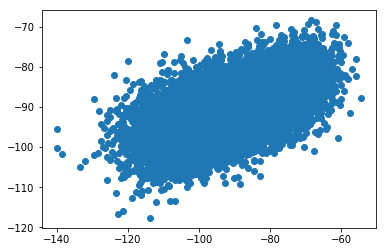

In [29]:
plt.scatter(testSet1['target'][100000:120000],predictions)

C:\Users\lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


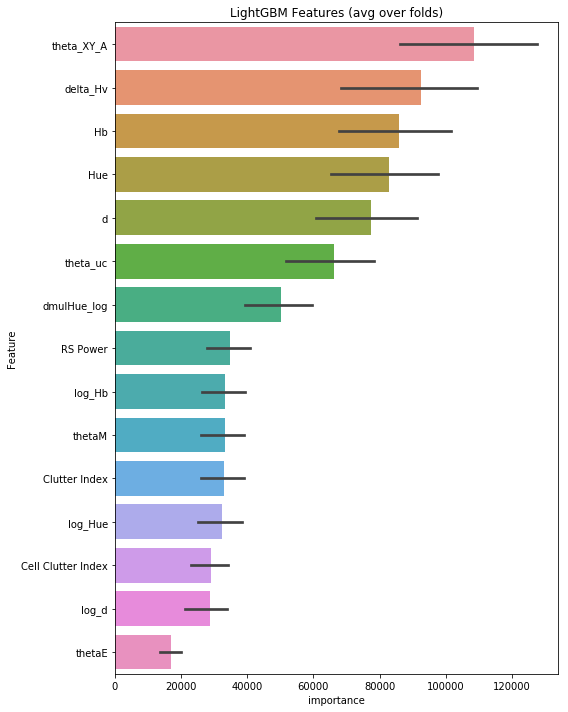

In [30]:
display_importances(feature_importance_df)